# DEMOGRAPHIC HEALTH

### Analyzing the Impact of Sociodemographic Factors on Health Resources Using Regularized Linear Regression

In [1]:
!pip install -r requirements.txt 

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
#Libraries

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import json
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from pickle import dump
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

**STEP 1: PROBLEM STATEMENT & DATA COLLECTION**

***1.1 PROBLEM STATEMENT***

**Health Resource and Sociodemographic Analysis:** What sociodemographic factors are most strongly associated with access to health resources in US counties? Is there a correlation between county-level income, education, and population density with the availability of health resources? Do counties with higher poverty rates tend to have fewer health resources?

**Resource Disparities Across Demographics:** Are there noticeable disparities in health resources across counties with different racial or ethnic compositions? Does the health resource allocation differ based on the predominant age groups or family structures in each county?

**Influence of Economic and Social Variables on Health Resource Allocation:** How do economic variables, such as unemployment rates or income levels, impact the availability and quality of health resources at the county level? Are counties with better economic indicators consistently better equipped in terms of health infrastructure?

**Geographic and Regional Variation:** Is there significant regional variation in the allocation of health resources? Which regions of the US have greater access to health services, and are these differences statistically significant? How do rural and urban counties compare in terms of health resource availability?

**Predictive Modeling and Analysis of Health Resources:** By using regularized linear regression, can we accurately predict health resource allocation based on sociodemographic data? How does the predictive accuracy evolve with different regularization parameters? Which variables have the strongest predictive influence, and what implications does this have for addressing health resource inequities?

***1.2 DATA COLLECTION***

In [3]:
pd.options.display.max_columns=None
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv")
df.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,R_NET_MIG_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,CI90LBINC_2018,CI90UBINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,13.636445,7738,13.917016,5826,10.478229,4050,7.284042,2014,3.622237,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,158,455,11.8,9.6,2.2,0.0,0.7,0.6,4204,12119,10552,10291,11.3,32.6,28.4,27.7,7587,13.8,19.3,19.5,59338,53628,65048,25957,25015,942,3.6,59338,119.0,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,Autauga,Alabama,1,1,42438,47.6,45.4,49.4,20181,35.8,34.2,37.3,15193,7.9,7.2,8.7,3345,8.6,7.3,9.9,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,12.539102,29986,13.753658,29932,13.728890,20936,9.602701,9368,4.296814,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,5403,2190,10.5,10.3,0.1,0.5,24.3,24.8,14310,40579,46025,46075,9.7,27.6,31.3,31.3,21069,9.8,13.9,13.1,57588,54437,60739,93849,90456,3393,3.6,57588,115.5,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,Baldwin,Alabama,1,3,170912,40.2,38.2,42.3,68790,29.7,28.4,31.0,50761,7.8,7.0,8.7,13414,8.6,7.2,10.1,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,12.354809,3278,13.174712,3076,12.3

In [4]:
df.to_csv("../data/raw/medical_insurance_data.csv", index=False)

**STEP 2: EXPLORATION & DATA CLEANING**

***2.1. EXPLORATION***

****2.1.1 Understanding the features****

To answer the above questions and develop a predictive model, we collected data on the following variables:

**1. Geographic Identification**

* `fips`: FIPS code for the county
* `STATE_FIPS`: FIPS code for the state
* `Urban_rural_code`: Urban/rural area classification

**2. Demographics and Age**

* `TOT_POP`: Total population
* Age groups (population and percentage of total):
    * `0-9`, `10-19`, `20-29`, `30-39`, `40-49`, `50-59`, `60-69`, `70-79`, `80+`
    * Percentage of the population in each age group (`0-9 y/o % of total pop`, etc.)
* Elderly population:
    * `Population Aged 60+`: Population aged 60+
    * `Percent of Population Aged 60+`: Percentage of the population aged 60+
* `county_pop2018_18 and older`: Population aged 18+ in 2018

**3. Race and Ethnicity**
* Population by racial group:
    * `White-alone pop`, `Black-alone pop`, `Native American/American Indian-alone pop`, `Asian-alone pop`, `Hawaiian/Pacific Islander-alone pop`, `Two or more races pop`
* Percentage by racial group:
    * `% White-alone`, `% Black-alone`, `% NA/AI-alone`, `% Asian-alone`, `% Hawaiian/PI-alone`, `% Two or more races`
    
**4. Population Change and Migration**
* `N_POP_CHG_2018`: Numeric change in resident population (2017-2018)
* `GQ_ESTIMATES_2018`: Group quarters population estimate (2018)
* Birth, death, and migration rates:
    * `R_birth_2018`, `R_death_2018`, `R_NATURAL_INC_2018`, `R_INTERNATIONAL_MIG_2018`, `R_DOMESTIC_MIG_2018`, `R_NET_MIG_2018`

**5. Education**
* Education levels (count and percentage):
    * `Less than a high school diploma 2014-18`, `High school diploma only 2014-18`, `Some college or associate's degree 2014-18`, `Bachelor's degree or higher 2014-18`
    * Corresponding percentages: `Percent of adults with less than a high school diploma 2014-18`, `Percent of adults with a high school diploma only 2014-18`, etc.
    
**6. Poverty and Income**

* `POVALL_2018`: Estimated number of people of all ages in poverty (2018)
* Poverty percentages:
    * `PCTPOVALL_2018`: Percentage of people in poverty (2018)
    * `PCTPOV017_2018`: Percentage of people under age 17 in poverty (2018)
    * `PCTPOV517_2018`: Percentage of children aged 5-17 in poverty
* Household income:
    * `MEDHHINC_2018`: Median household income estimate (2018)
    * 90% confidence interval for median household income: `CI90LBINC_2018` (lower bound), `CI90UBINC_2018` (upper bound)
    * `Med_HH_Income_Percent_of_State_Total_2018`: County median household income as a percent of state median (2018)

**7. Employment**

* `Civilian_labor_force_2018`: Civilian labor force annual average
* `Employed_2018`: Number of employed individuals (annual average)
* `Unemployed_2018`: Number of unemployed individuals (annual average)
* `Unemployment_rate_2018`: Unemployment rate

**8. Health Resources and Infrastructure**

* Health professionals per 100,000 population (2018):
    * `Active Physicians per 100000 Population 2018 (AAMC)`: Active physicians
    * `Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)`: Active primary care physicians
    * `Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)`: Primary care patient care physicians
    * `Active General Surgeons per 100000 Population 2018 (AAMC)`: General surgeons
* Nursing and medical assistance professionals (2019):
    * `Total nurse practitioners (2019)`, `Total physician assistants (2019)`, etc.
* Hospital infrastructure:
    * `Total Hospitals (2019)`: Total number of hospitals
    * `ICU Beds_x`: Number of ICU beds per county

**9. Health Conditions Prevalence**

* General health conditions:
    * `anycondition_prevalence`, `anycondition_Lower 95% CI`, `anycondition_Upper 95% CI`, `anycondition_number`
* Obesity prevalence:
    * `Obesity_prevalence`, `Obesity_Lower 95% CI`, `Obesity_Upper 95% CI`, `Obesity_number`
* Other conditions:
    * `Heart disease_prevalence`, `COPD_prevalence`, `diabetes_prevalence`, `CKD_prevalence` (each with prevalence rates, confidence intervals, and population counts)

In [5]:
# Obtaining Dataset dimensions:
print("Dataset dimensions:")
print(df.shape)

Dataset dimensions:
(3140, 108)


In [6]:
# Obtaining Dataset informations:
print("Dataset informations:")
print(df.info())

Dataset informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB
None


In [7]:
# Analyze the types of information we have
print("Data types present in the dataset:", df.dtypes.unique())

# Identify numerical and categorical variables
numerical_vars = df.select_dtypes(include=['float', 'int']).columns
categorical_vars = df.select_dtypes(include=['O']).columns

# Count the number of numerical and categorical variables
num_numerical_vars = len(numerical_vars)
num_categorical_vars = len(categorical_vars)

# Display results
print(f"Number of categorical variables: {num_categorical_vars}")
print("Categorical variables:", list(categorical_vars))
print('\n')
print(f"Number of numerical variables: {num_numerical_vars}")
print("Numerical variables:", list(numerical_vars))

Data types present in the dataset: [dtype('int64') dtype('float64') dtype('O')]
Number of categorical variables: 2
Categorical variables: ['COUNTY_NAME', 'STATE_NAME']


Number of numerical variables: 106
Numerical variables: ['fips', 'TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct', '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop', '30-39', '30-39 y/o % of total pop', '40-49', '40-49 y/o % of total pop', '50-59', '50-59 y/o % of total pop', '60-69', '60-69 y/o % of total pop', '70-79', '70-79 y/o % of total pop', '80+', '80+ y/o % of total pop', 'White-alone pop', '% White-alone', 'Black-alone pop', '% Black-alone', 'Native American/American Indian-alone pop', '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone', 'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone', 'Two or more races pop', '% Two or more races', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018', 'GQ_ESTIMATES_2018', 'R_birth_2018', 'R_death_2018', 'R_NATURAL_INC_2018', 'R_INTERNATIONAL_MIG_2018', 'R_DOM

#### Statements

* This DataFame is composed by 3140 rows and 108 columns (variables).
* The data has:
    * 2 categorical variables
    * 106 numerical variables

**2.2 DATA CLEANING**

***2.2.1 ELIMINATE DUPLICATES***

In this step, I will eliminate duplicates, which is essential to ensure data integrity. Duplicates can distort analyses, introduce bias, and affect model accuracy. This step helps keep the dataset clean by representing each input uniquely and reliably. 

In [8]:
# Display initial row count
initial_row_count = df.shape[0]

# Check and remove duplicates
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicate rows have been removed. Row count reduced from {initial_row_count} to {df.shape[0]}.")
else:
    print("No duplicate rows found.")

Number of duplicate rows: 0
No duplicate rows found.


* there are no duplicates ​​in this dataframe.

***2.2.2 ELIMINATE IRRELEVANT INFORMATION***

#### Statement:
To simplify and focus our analysis on the relationship between sociodemographic factors and healthcare resources, some variables were identified as irrelevant and eliminated. These variables include geographic codes and identifiers (`flips` and `STATE_FIPS`), details about population changes and migration (`R_INTERNATIONAL_MIG_2018`, `R_DOMESTIC_MIG_2018`, `R_NET_MIG_2018`, `N_POP_CHG_2018`), confidence intervals around income (`CI90LBINC_2018`, `CI90UBINC_2018`), overly granular racial and age distribution details, and other redundant information that does not directly contribute to the analytical objectives. Removing these variables ensures that our dataset remains focused on the key variables, reducing noise and improving processing and modeling efficiency.

In [9]:
irrelevant_columns = [
    'fips', 'STATE_FIPS', 'R_INTERNATIONAL_MIG_2018', 'R_DOMESTIC_MIG_2018', 
    'R_NET_MIG_2018', 'N_POP_CHG_2018', 'CI90LBINC_2018', 'CI90UBINC_2018', 
    'Urban_rural_code', '0-9', '19-Oct', '20-29', '30-39', '40-49', '50-59', 
    '60-69', '70-79', '80+', '0-9 y/o % of total pop', '10-19 y/o % of total pop', 
    '20-29 y/o % of total pop', '30-39 y/o % of total pop', '40-49 y/o % of total pop', 
    '50-59 y/o % of total pop', '60-69 y/o % of total pop', '70-79 y/o % of total pop', 
    '80+ y/o % of total pop', 'Med_HH_Income_Percent_of_State_Total_2018', 
    'GQ_ESTIMATES_2018'
]


df = df.drop(columns=[col for col in irrelevant_columns if col in df.columns])

# Verificando se as colunas foram removidas
print("Remaining columns in the dataset:")
print(df.columns)



Remaining columns in the dataset:
Index(['TOT_POP', 'White-alone pop', '% White-alone', 'Black-alone pop',
       '% Black-alone', 'Native American/American Indian-alone pop',
       '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone',
       'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone',
       'Two or more races pop', '% Two or more races', 'POP_ESTIMATE_2018',
       'R_birth_2018', 'R_death_2018', 'R_NATURAL_INC_2018',
       'Less than a high school diploma 2014-18',
       'High school diploma only 2014-18',
       'Some college or associate's degree 2014-18',
       'Bachelor's degree or higher 2014-18',
       'Percent of adults with less than a high school diploma 2014-18',
       'Percent of adults with a high school diploma only 2014-18',
       'Percent of adults completing some college or associate's degree 2014-18',
       'Percent of adults with a bachelor's degree or higher 2014-18',
       'POVALL_2018', 'PCTPOVALL_2018', 'PCTPOV017_2018', 'PCTPOV517_201

In [10]:
df.head()

,TOT_POP,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number
0,55601,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,11.8,9.6,2.2,4204,12119,10552,10291,11.3,32.6,28.4,27.7,7587,13.8,19.3,19.5,59338,25957,25015,942,3.6,59338,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,Autauga,Alabama,1,42438,47.6,45.4,49.4,20181,35.8,34.2,37.3,15193,7.9,7.2,8.7,3345,8.6,7.3,9.9,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326
1,218022,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,10.5,10.3,0.1,14310,40579,46025,46075,9.7,27.6,31.3,31.3,21069,9.8,13.9,13.1,57588,93849,90456,3393,3.6,57588,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,Baldwin,Alabama,3,170912,40.2,38.2,42.3,68790,29.7,28.4,31.0,50761,7.8,7.0,8.7,13414,8.6,7.2,10.1,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479
2,24881,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,0.184880,307,1.233873,24881,10.4,12.9,-2.5,4901,6486,4566,2220,27.0,35.7,25.1,12.2,6788,30.9,43.9,36.7,34382,8373,7940,433,5.2,34382,217.1,196.7,77.2,71.2,7.6,6.9,12.914231,2.723340,0.514126,11.631462,9.508784,32.283033,5,26201,6150,23.5,Barbour,Alabama,5,19689,57.5,55.6,59.1,11325,40.7,39.5,41.9,8013,11.0,10.1,11.8,2159,12.1,10.7,13.3,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887
3,22400,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,0.116071,242,1.080357,22400,11.1,11.4,-0.3,2650,7471,3846,1813,16.8,47.3,24.4,11.5,4400,21.8,27.8,26.3,46064,8661,8317,344,4.0,46064,217.1,196.7,77.2,71.2,7.6,6.9,11.626493,2.451783,0.462860,10.471635,8.560619,29.063942,0,22580,4773,21.1,Bibb,Alabama,7,17813,51.6,49.6,53.4,9190,38.7,37.4,40.2,6894,8.6,7.9,9.3,1533,10.0,8.8,11.3,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595
4,57840,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,0.1

In [11]:
print("Columns in the dataset:")
print(df.columns.tolist())


Columns in the dataset:
['TOT_POP', 'White-alone pop', '% White-alone', 'Black-alone pop', '% Black-alone', 'Native American/American Indian-alone pop', '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone', 'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone', 'Two or more races pop', '% Two or more races', 'POP_ESTIMATE_2018', 'R_birth_2018', 'R_death_2018', 'R_NATURAL_INC_2018', 'Less than a high school diploma 2014-18', 'High school diploma only 2014-18', "Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18", 'Percent of adults with less than a high school diploma 2014-18', 'Percent of adults with a high school diploma only 2014-18', "Percent of adults completing some college or associate's degree 2014-18", "Percent of adults with a bachelor's degree or higher 2014-18", 'POVALL_2018', 'PCTPOVALL_2018', 'PCTPOV017_2018', 'PCTPOV517_2018', 'MEDHHINC_2018', 'Civilian_labor_force_2018', 'Employed_2018', 'Unemployed_2018', 'Unemployment_rate_2018', 'M

**STEP 3: ANALYSIS OF UNIVARIATE VARIABLES**

In [12]:
num = ['int64', 'float64']
cat = ['O']

df_numerical = df.select_dtypes(num)
df_categorical = df.select_dtypes(cat)

**3.1 ANALYSIS OF CATEGORICAL VARIABLES**

In [13]:
df_categorical.head(3)

,COUNTY_NAME,STATE_NAME
0,Autauga,Alabama
1,Baldwin,Alabama
2,Barbour,Alabama


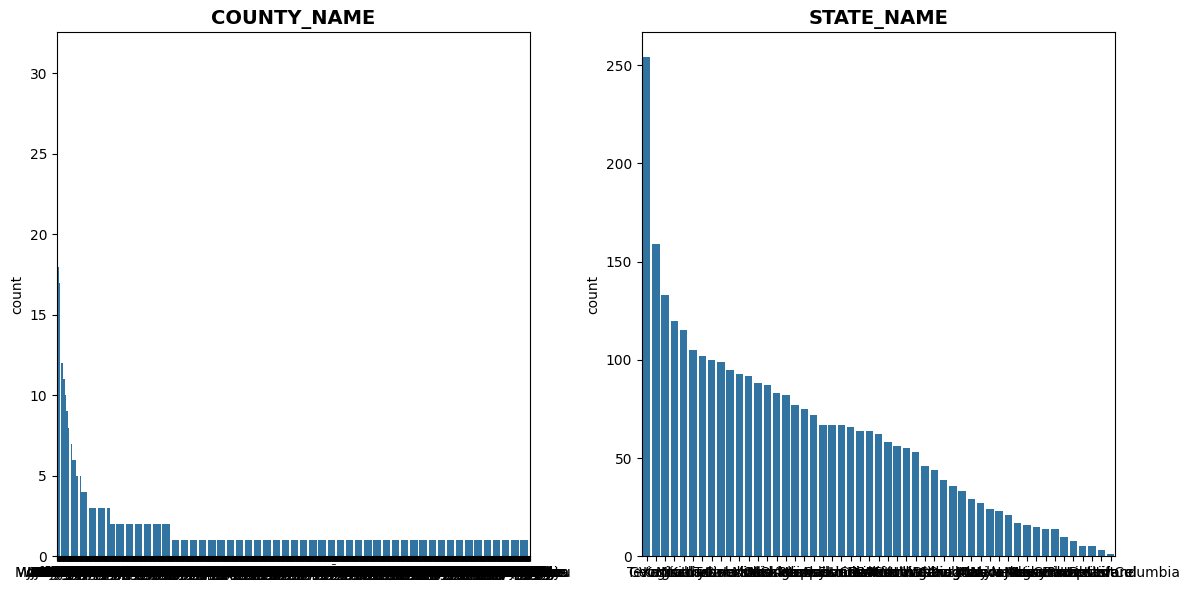

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for 'COUNTY_NAME'
sns.countplot(ax=ax[0], data=df_categorical, x='COUNTY_NAME', order=df_categorical['COUNTY_NAME'].value_counts().index)
ax[0].set_title("COUNTY_NAME", fontsize=14, fontweight='bold')
ax[0].set_xlabel(None)  # Remove x-axis label

# Plot for 'STATE_NAME'
sns.countplot(ax=ax[1], data=df_categorical, x='STATE_NAME', order=df_categorical['STATE_NAME'].value_counts().index)
ax[1].set_title("STATE_NAME", fontsize=14, fontweight='bold')
ax[1].set_xlabel(None)  # Remove x-axis label

# Adjust layout
plt.tight_layout()
plt.show()


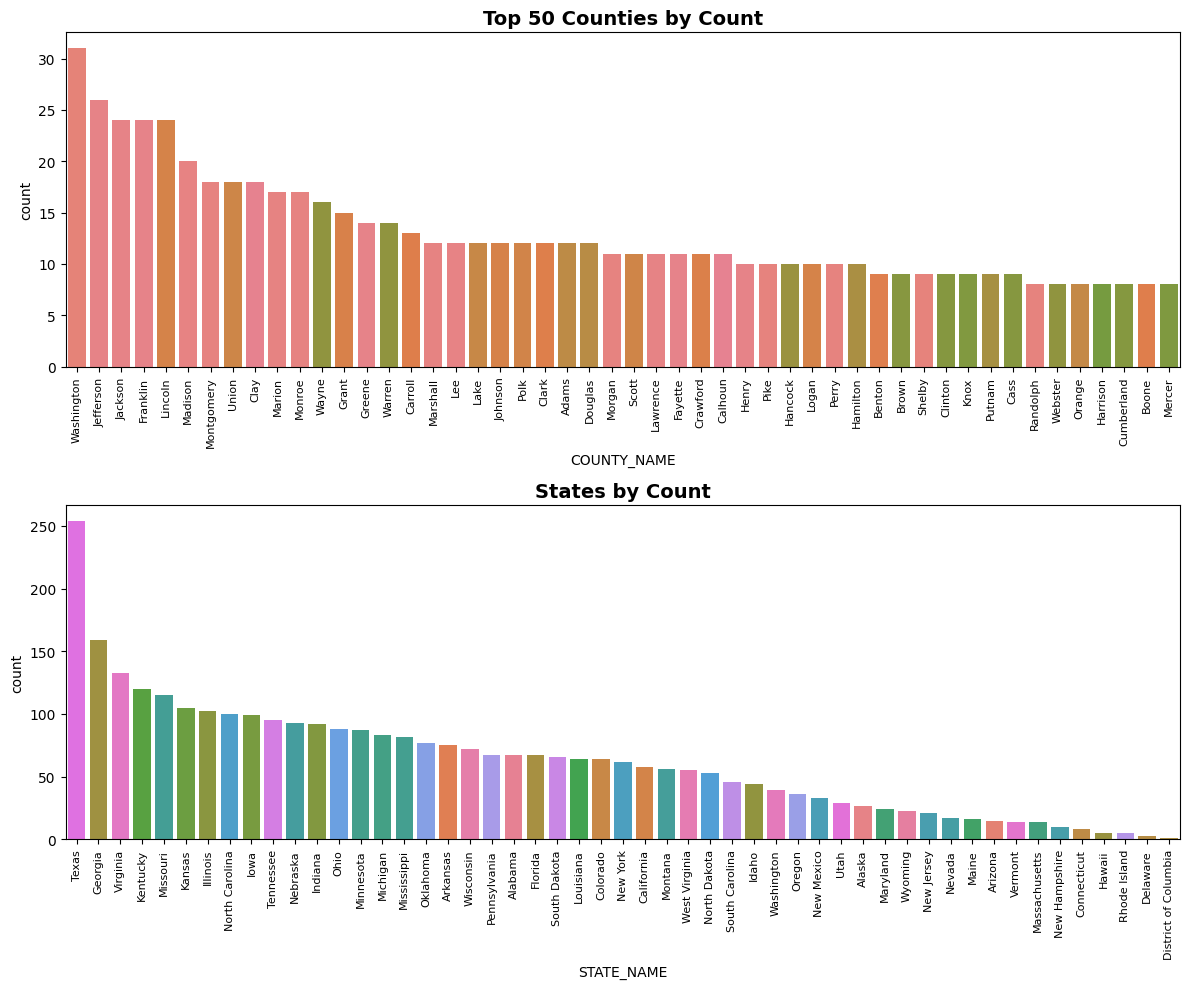

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot for 'COUNTY_NAME' - Top 50
sns.countplot(ax=ax[0], data=df_categorical, x='COUNTY_NAME', order=df_categorical['COUNTY_NAME'].value_counts().index[:50], hue='COUNTY_NAME')
ax[0].set_title("Top 50 Counties by Count", fontsize=14, fontweight='bold')

# Plot for 'STATE_NAME'
sns.countplot(ax=ax[1], data=df_categorical, x='STATE_NAME', order=df_categorical['STATE_NAME'].value_counts().index, hue='STATE_NAME')
ax[1].set_title("States by Count", fontsize=14, fontweight='bold')

# Adjust x-axis labels using set_tick_params
for a in ax:
    a.tick_params(axis='x', labelrotation=90, labelsize=8)

plt.tight_layout()
plt.show()



**3.2 ANALYSIS OF NUMERICAL VARIABLES**

 ##### FROM STRING TO NUMERICAL TRANSFORMATION -> JSON SAVING

**STEP 4: ANALYSIS OF MULTIVARIATE VARIABLES**

**4.3 CORRELATION MATRIX**